In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    mean_squared_error, 
    matthews_corrcoef
)
from sklearn.model_selection import (
    TimeSeriesSplit, 
    cross_val_score, 
    GridSearchCV, 
    train_test_split
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier,VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.datasets import load_breast_cancer

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.base import BaseEstimator, ClassifierMixin

d:\Program Files\Python\Python311\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [3]:
df = pd.read_csv('../Feature Engineering/EPL_Final_cleaned_features_v2.csv')
df.head(5)

,Temperature,Humidity,WindDirection,Precipitation,WindSpeed,Home_Prv_FTHG,Home_Prv_HS,Home_Prv_HST,Home_Prv_HF,Home_Prv_HC,...,WeatherCode_Clear,WeatherCode_Clouds,WeatherCode_Drizzle,WeatherCode_Fog,WeatherCode_Haze,WeatherCode_Mist,WeatherCode_Rain,WeatherCode_Snow,Time_of_Day_Afternoon,Time_of_Day_Evening
0,1.589044,-0.947690,0.173322,-0.362486,1.677221,0.561811,0.043716,-0.045927,-0.171534,0.002643,...,0,1,0,0,0,0,0,0,1,0
1,1.917548,-0.815443,0.500378,-0.362486,1.280300,1.363757,2.156421,1.555162,-0.443552,1.065042,...,1,0,0,0,0,0,0,0,1,0
2,1.400248,-0.418701,0.816532,-0.362486,0.273563,0.561811,-0.340412,-0.846471,-1.259605,-0.351490,...,0,1,0,0,0,0,0,0,1,0
3,1.811823,-0.683196,0.500378,-0.362486,0.558625,0.561811,-1.300732,-0.446199,2.004609,-1.413890,...,0,0,0,0,0,0,1,0,1,0
4,2.011946,-0.881566,0.500378,-0.362486,0.558625,1.363757,0.811972,2.355707,0.100484,0.710909,...,1,0,0,0,0,0,0,0,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 55 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Temperature                1072 non-null   float64
 1   Humidity                   1072 non-null   float64
 2   WindDirection              1072 non-null   float64
 3   Precipitation              1072 non-null   float64
 4   WindSpeed                  1072 non-null   float64
 5   Home_Prv_FTHG              1072 non-null   float64
 6   Home_Prv_HS                1072 non-null   float64
 7   Home_Prv_HST               1072 non-null   float64
 8   Home_Prv_HF                1072 non-null   float64
 9   Home_Prv_HC                1072 non-null   float64
 10  Home_Prv_HY                1072 non-null   float64
 11  Home_Prv_HR                1072 non-null   float64
 12  Away_Prv_FTAG              1072 non-null   float64
 13  Away_Prv_AS                1072 non-null   float

In [4]:
train_data = df[df['season'].isin(['2019-2020', '2020-2021'])]
test_data = df[df['season'] == '2021-2022']

### Model with Weather Data:

In [4]:
# Splitting into features and target variable
X_train = train_data.drop(columns=['FTR','Date', 'Time', 'season','HomeTeam','AwayTeam'])
y_train = train_data['FTR']
X_test = test_data.drop(columns=['FTR','Date', 'Time', 'season','HomeTeam','AwayTeam'])
y_test = test_data['FTR']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((722, 51), (722,), (350, 51), (350,))

In [6]:
param_lr = {'C': 1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
param_rf = {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 50}
param_svm = {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.0001}
param_xgb = {'colsample_bytree': 1.0, 'enable_categorical': False, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
param_gbm = {'max_depth': 7, 'num_leaves': 18, 'learning_rate': 0.025478141561655225, 'min_child_samples': 70, 'subsample': 0.8500380101654152, 'colsample_bytree': 0.9989014368002574}


# Logistic Regression
lr = LogisticRegression(**param_lr)

# Random Forest
rf = RandomForestClassifier(**param_rf, random_state=42)

# Support Vector Machine
svm = SVC(**param_svm, random_state=42)

# XGBoost
xgb = XGBClassifier(**param_xgb, random_state=42)

# LightGBM
lgb = LGBMClassifier(**param_gbm)

# CNN model
# cnn_clf = KerasCNNClassifier(input_shape=(X_train.shape[1], 1), epochs=100, batch_size=32, verbose=1)


[LightGBM] [Info] Number of positive: 303, number of negative: 419
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1173
[LightGBM] [Info] Number of data points in the train set: 722, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419668 -> initscore=-0.324138
[LightGBM] [Info] Start training from score -0.324138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

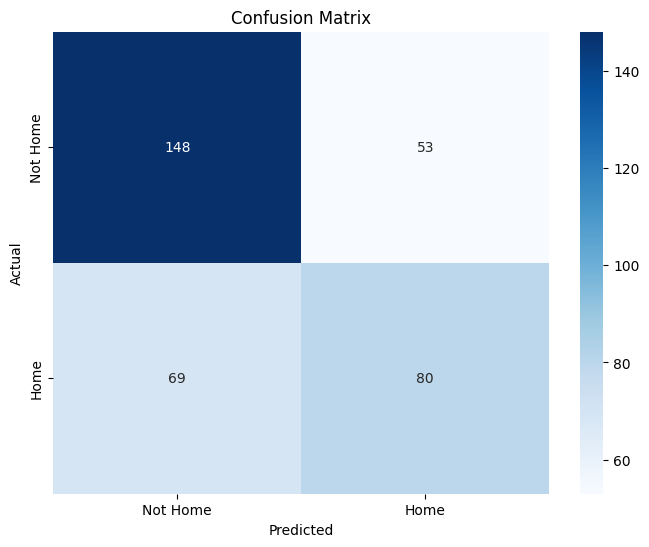

MCC: 0.2783336410152494
accuracy: 0.6514285714285715
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       201
           1       0.60      0.54      0.57       149

    accuracy                           0.65       350
   macro avg       0.64      0.64      0.64       350
weighted avg       0.65      0.65      0.65       350



In [7]:
# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr),
        # ('rf', rf),
        ('svm', svm),
        # ('xgb', xgb),
        ('lgb', lgb)
        # ('cnn', cnn_clf)
    ],
    voting='hard'  # Use 'hard' for majority voting, 'soft' for weighted average probabilities
)

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = voting_clf.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

In [8]:
pd.DataFrame(y_pred,columns=['Voting_y_pred']).to_csv('7.Voting_y_pred_with_weather.csv')

Stacking Classifier:

[LightGBM] [Info] Number of positive: 303, number of negative: 419
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1173
[LightGBM] [Info] Number of data points in the train set: 722, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419668 -> initscore=-0.324138
[LightGBM] [Info] Start training from score -0.324138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

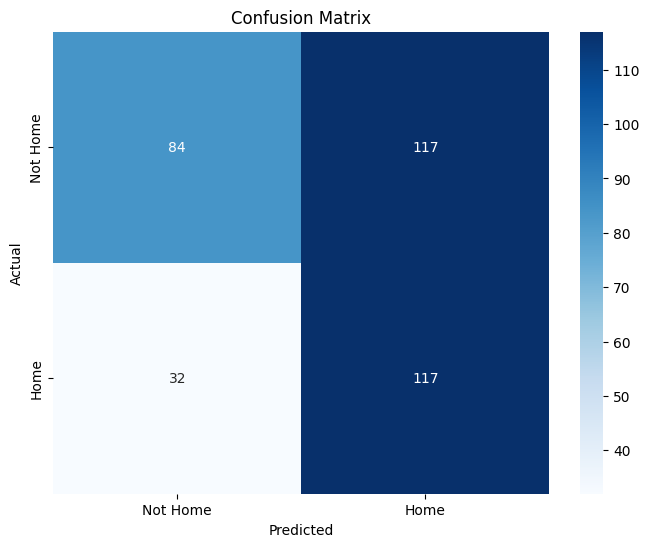

MCC: 0.213383639944693
Accuracy: 0.5742857142857143
              precision    recall  f1-score   support

           0       0.72      0.42      0.53       201
           1       0.50      0.79      0.61       149

    accuracy                           0.57       350
   macro avg       0.61      0.60      0.57       350
weighted avg       0.63      0.57      0.56       350



In [9]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base learners
base_learners = [
    ('lr', lr),
    # ('rf', rf),
    ('svm', svm),
    # ('xgb', xgb),
    ('lgb', lgb)
    # ('cnn', cnn_clf)
]


# Create the Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=svm,
    cv=5  
)

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = stacking_clf.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print evaluation metrics
print(f'MCC: {mcc}')
print(f'Accuracy: {accuracy}')
print(classification_report_output)

In [10]:
pd.DataFrame(y_pred,columns=['Stacking_y_pred']).to_csv('8.Stacking_y_pred_with_weather.csv')

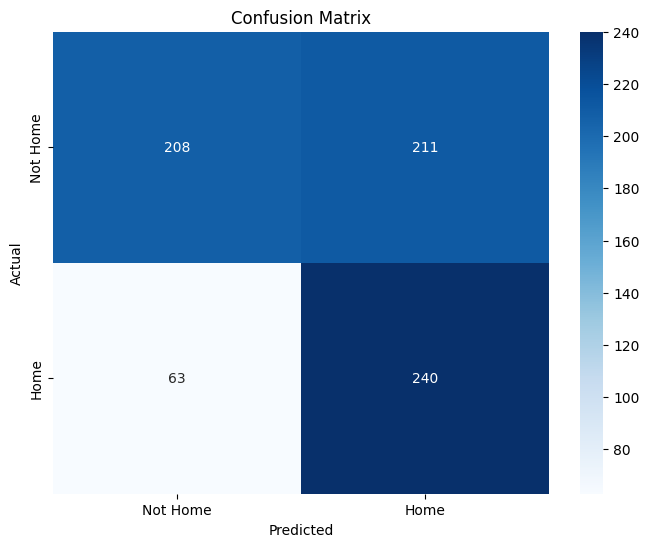

MCC: 0.2940357293664939
accuracy: 0.6204986149584487
              precision    recall  f1-score   support

           0       0.77      0.50      0.60       419
           1       0.53      0.79      0.64       303

    accuracy                           0.62       722
   macro avg       0.65      0.64      0.62       722
weighted avg       0.67      0.62      0.62       722



In [22]:
# Predicting on the TRAIN data
y_pred_train = stacking_clf.predict(X_train)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_train, y_pred_train)
accuracy = accuracy_score(y_train, y_pred_train)
classification_report_output = classification_report(y_train, y_pred_train)

cm = confusion_matrix(y_train, y_pred_train)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

In [27]:
result = pd.read_csv('contigency_table.csv')
result.head(5)

,Test Label,LR,RF,SVM,XGB,BO-LightGBM,CNN,Stacking,Hard Voting,B365_Pred,WH_Pred,PS_Pred,Max_Pred
0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,1,0,0,1,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,1,1,0,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:

contingency_table = pd.crosstab(result['Stacking'], result['B365_Pred'], margins=True, margins_name="Total")
contingency_table


B365_Pred,0,1,Total
Stacking,,,
0,87,49,136
1,47,167,214
Total,134,216,350


In [28]:
contingency_table = pd.crosstab(result['Hard Voting'], result['B365_Pred'], margins=True, margins_name="Total")
contingency_table

B365_Pred,0,1,Total
Hard Voting,,,
0,108,105,213
1,26,111,137
Total,134,216,350


In [ ]:
contingency_table = pd.crosstab(result['Stacking'], result['B365_Pred'], margins=True, margins_name="Total")
contingency_table

Voting with all classifers:

[LightGBM] [Info] Number of positive: 303, number of negative: 419
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1173
[LightGBM] [Info] Number of data points in the train set: 722, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419668 -> initscore=-0.324138
[LightGBM] [Info] Start training from score -0.324138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

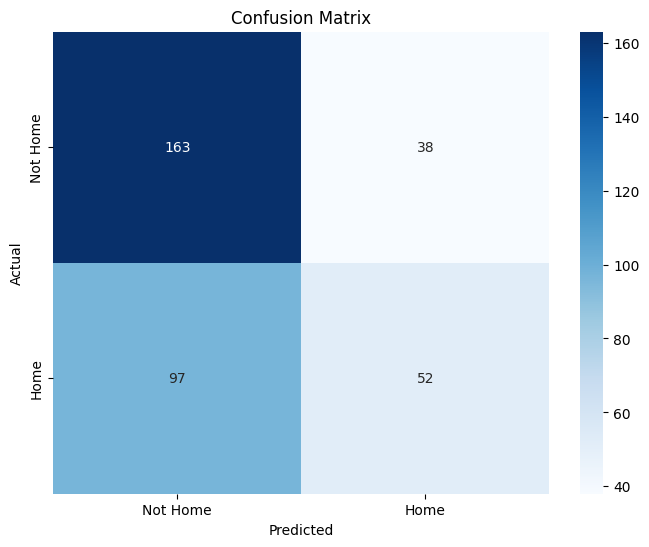

MCC: 0.18094076485568497
accuracy: 0.6142857142857143
              precision    recall  f1-score   support

           0       0.63      0.81      0.71       201
           1       0.58      0.35      0.44       149

    accuracy                           0.61       350
   macro avg       0.60      0.58      0.57       350
weighted avg       0.61      0.61      0.59       350



In [11]:
# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('rf', rf),
        ('svm', svm),
        ('xgb', xgb),
        ('lgb', lgb)
        # ('cnn', cnn_clf)
    ],
    voting='hard'  # Use 'hard' for majority voting, 'soft' for weighted average probabilities
)

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = voting_clf.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

In [12]:
pd.DataFrame(y_pred,columns=['Voting_y_pred']).to_csv('9.Voting_all_y_pred_with_weather.csv')

Stacking all classifers:

[LightGBM] [Info] Number of positive: 303, number of negative: 419
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1173
[LightGBM] [Info] Number of data points in the train set: 722, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419668 -> initscore=-0.324138
[LightGBM] [Info] Start training from score -0.324138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

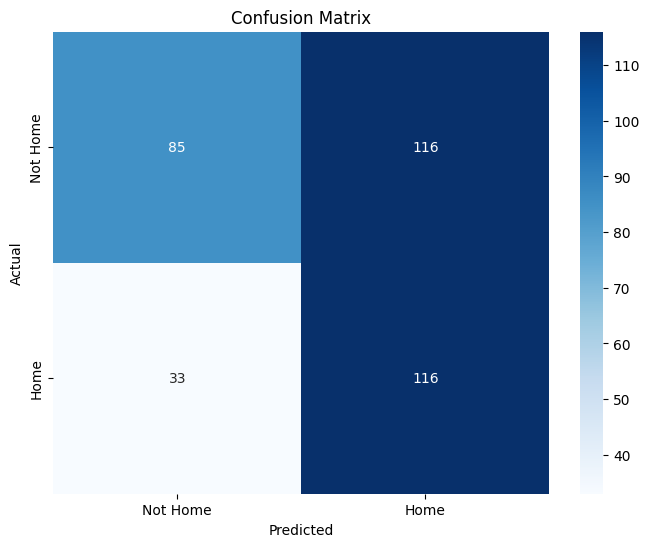

MCC: 0.21066150078790197
Accuracy: 0.5742857142857143
              precision    recall  f1-score   support

           0       0.72      0.42      0.53       201
           1       0.50      0.78      0.61       149

    accuracy                           0.57       350
   macro avg       0.61      0.60      0.57       350
weighted avg       0.63      0.57      0.57       350



In [16]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base learners
base_learners = [
    ('lr', lr),
    ('rf', rf),
    ('svm', svm),
    ('xgb', xgb),
    ('lgb', lgb)
    # ('cnn', cnn_clf)
]


# Create the Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=svm,
    cv=5  
)

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = stacking_clf.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print evaluation metrics
print(f'MCC: {mcc}')
print(f'Accuracy: {accuracy}')
print(classification_report_output)

In [17]:
pd.DataFrame(y_pred,columns=['Stacking_y_pred']).to_csv('10.Stacking_All_y_pred_with_weather.csv')

### Model without Weather Data:

In [5]:
# Splitting into features and target variable
X_train = train_data.drop(columns=['FTR','Date', 'Time', 'season','HomeTeam','AwayTeam','Temperature', 'Humidity', 'WindDirection', 'Precipitation', 'WindSpeed', 
                                   'WeatherCode_Clear', 'WeatherCode_Clouds', 'WeatherCode_Drizzle', 'WeatherCode_Fog', 'WeatherCode_Haze', 'WeatherCode_Mist', 'WeatherCode_Rain', 'WeatherCode_Snow'])
y_train = train_data['FTR']
X_test = test_data.drop(columns=['FTR','Date', 'Time', 'season','HomeTeam','AwayTeam','Temperature', 'Humidity', 'WindDirection', 'Precipitation', 'WindSpeed', 
                                   'WeatherCode_Clear', 'WeatherCode_Clouds', 'WeatherCode_Drizzle', 'WeatherCode_Fog', 'WeatherCode_Haze', 'WeatherCode_Mist', 'WeatherCode_Rain', 'WeatherCode_Snow'])
y_test = test_data['FTR']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((722, 38), (722,), (350, 38), (350,))

In [47]:
param_lr = {'C': 10, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.001}
param_rf = {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100}
param_svm = {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.0001}
param_xgb = {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.6}
param_gbm = {'max_depth': 6, 'num_leaves': 57, 'learning_rate': 0.026682465648473243, 'min_child_samples': 79, 'subsample': 0.5335887645947657, 'colsample_bytree': 0.929753308144078}


# Logistic Regression
lr = LogisticRegression(**param_lr)

# Random Forest
rf = RandomForestClassifier(**param_rf, random_state=42)

# Support Vector Machine
svm = SVC(**param_svm, random_state=42)

# XGBoost
xgb = XGBClassifier(**param_xgb, random_state=42)

# LightGBM
lgb = LGBMClassifier(**param_gbm)

# CNN model
# cnn_clf = KerasCNNClassifier(input_shape=(X_train.shape[1], 1), epochs=100, batch_size=32, verbose=1)


[LightGBM] [Info] Number of positive: 303, number of negative: 419
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 722, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419668 -> initscore=-0.324138
[LightGBM] [Info] Start training from score -0.324138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

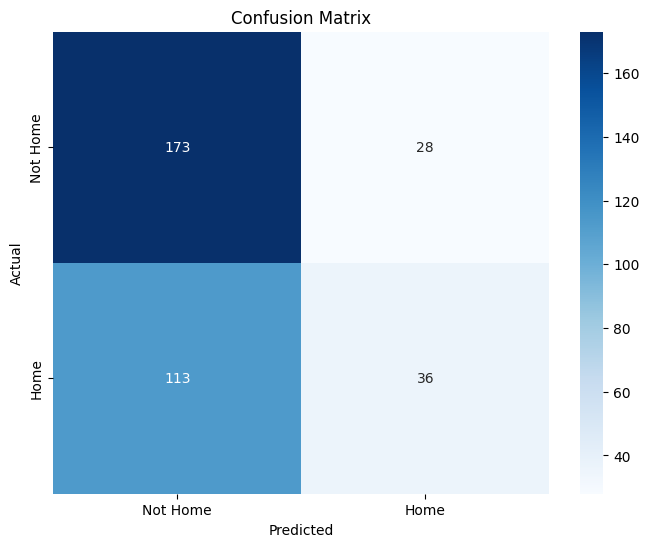

MCC: 0.13086532693601452
accuracy: 0.5971428571428572
              precision    recall  f1-score   support

           0       0.60      0.86      0.71       201
           1       0.56      0.24      0.34       149

    accuracy                           0.60       350
   macro avg       0.58      0.55      0.52       350
weighted avg       0.59      0.60      0.55       350



In [67]:
# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr),
        # ('rf', rf),
        ('svm', svm),
        # ('xgb', xgb),
        ('lgb', lgb)
        # ('cnn', cnn_clf)
    ],
    voting='hard'  # Use 'hard' for majority voting, 'soft' for weighted average probabilities
)

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = voting_clf.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

In [68]:
voting_clf.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,

In [73]:
df_voting_pred = pd.DataFrame(voting_clf.predict_proba(X_test)[:,1], columns= ['Y_Pred_Prob_Voting'])
df_voting_pred['Y_Pred_Prob_Voting'] = round(df_voting_pred['Y_Pred_Prob_Voting'],2)
df_voting_pred.to_csv('Y_Pred_Prob_Voting.csv', index= False)

In [53]:
y_test

722     0
723     1
724     0
725     1
726     0
       ..
1067    1
1068    1
1069    1
1070    1
1071    0
Name: FTR, Length: 350, dtype: int64